We're using pretrained Mask R-CNN model in https://github.com/matterport/Mask_RCNN/


In [25]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [26]:
DATA_DIR = '/kaggle/input'
ROOT_DIR = '/kaggle/working'

# Cloning Mask-RCNN model from github.

In [27]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 137.67 MiB | 36.45 MiB/s, done.
Resolving deltas: 100% (558/558), done.
Checking connectivity... done.


In [28]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [29]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [30]:
# Download COCO pre-trained weights
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


# Helper functions

In [31]:
# Returns list of dcm fileplaths
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

# Returns image filepath and their corresponding annotations
def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [32]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
     
    NAME = 'pneumonia' # Experiment name 
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    BACKBONE = 'resnet50'
    NUM_CLASSES = 2
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.7
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 200
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [33]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        self.add_class('pneumonia', 1, 'Lung Opacity')
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

# Data processing

In [35]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [36]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [39]:
ORIG_SIZE = 1024

In [40]:
# split dataset into training and validation dataset 
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = int(0.05 * len(image_fps_list))
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

25350 1334


In [41]:
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [42]:
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

# Model Training

In [44]:
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

In [45]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [46]:
LEARNING_RATE = 0.005

In [47]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)
history = model.keras_model.history.history.copy()


Starting at epoch 0. LR=0.01

Checkpoint Path: /kaggle/working/pneumonia20221210T1933/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4  

In [48]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=7,
            layers='all',
            augmentation=augmentation)
news = model.keras_model.history.history
for k in news: history[k] = history[k] + news[k]


Starting at epoch 2. LR=0.005

Checkpoint Path: /kaggle/working/pneumonia20221210T1933/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

In [50]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=15,
            layers='all',
            augmentation=augmentation)
news = model.keras_model.history.history
for k in news: history[k] = history[k] + news[k]


Starting at epoch 7. LR=0.001

Checkpoint Path: /kaggle/working/pneumonia20221210T1933/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b  

In [51]:
print(news)
print(history)

{'val_loss': [1.2845248365402222, 1.326075977087021, 1.2497450017929077, 1.2574406504631042, 1.256157205104828, 1.2630465972423552, 1.2578339982032776, 1.2540998601913451], 'val_rpn_class_loss': [0.026643633656203747, 0.02828007297590375, 0.02490645498037338, 0.02482836341485381, 0.024375034999102353, 0.02462427329272032, 0.022659214232116937, 0.02545882949605584], 'val_rpn_bbox_loss': [0.34757002383470537, 0.37968476235866544, 0.3252993211150169, 0.34276214987039566, 0.3275559103488922, 0.35893029898405077, 0.3295386692881584, 0.366499160528183], 'val_mrcnn_class_loss': [0.17319305047392844, 0.18400524377822877, 0.18033866479992866, 0.1779482139647007, 0.1773434779047966, 0.16726559907197952, 0.17194708496332167, 0.1530036748945713], 'val_mrcnn_bbox_loss': [0.3708620202541351, 0.36518600314855576, 0.36148798525333403, 0.3595801654458046, 0.3632274740934372, 0.35478765666484835, 0.3690298438072205, 0.3496556428074837], 'val_mrcnn_mask_loss': [0.3662428277730942, 0.36890654802322387, 0.

In [52]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.650598,0.053801,0.428729,0.305151,0.479914,0.383001,1.853652,0.054569,0.475891,0.361216,0.540242,0.421732
2,1.676778,0.046265,0.575403,0.251143,0.420244,0.383718,1.756773,0.054415,0.564721,0.290166,0.462344,0.385123
3,1.539666,0.041501,0.423543,0.280041,0.428091,0.366480,1.630573,0.049543,0.486482,0.271374,0.428575,0.394589
4,1.435464,0.037265,0.413995,0.221849,0.399913,0.362431,1.485934,0.041748,0.415789,0.231358,0.409115,0.387914
5,1.438875,0.033758,0.369290,0.256776,0.407022,0.372017,1.449230,0.034773,0.382610,0.250192,0.398140,0.383503
6,1.369448,0.030359,0.424234,0.162637,0.380910,0.371294,1.408440,0.032059,0.367421,0.237497,0.392133,0.379317
7,1.394568,0.035314,0.385094,0.233150,0.383867,0.357129,1.404024,0.032606,0.382205,0.224317,0.385925,0.378957
8,1.284525,0.026644,0.347570,0.173193,0.370862,0.366243,1.294598,0.028082,0.331784,0.191775,0.366827,0.376116
9,1.326076,0.028280,0.379685,0.184005,0.365186,0.368907,1.249906,0.025883,0.325070,0.178836,0.349657,0.370446
10,1.249745,0.024906,0.325299,0.180339,0.361488,0.357699,1.256586,0.026483,0.330105,0.178085,0.350069,0.371830


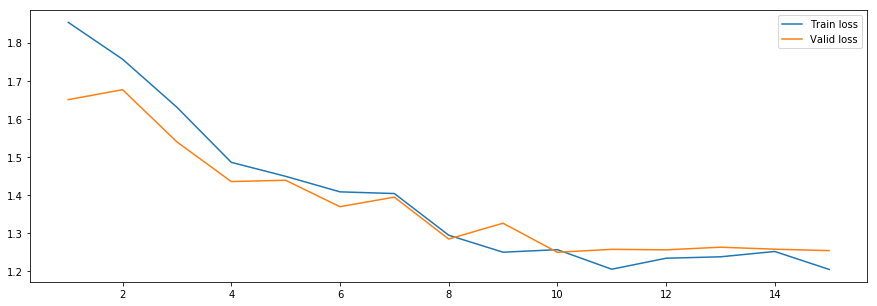

In [53]:
plt.figure(figsize=(15,5))
plt.subplot(111)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.show()

In [54]:
model_path = '/kaggle/working/pneumonia20221210T1933/mask_rcnn_pneumonia_0015.h5'
print('Found model {}'.format(model_path))

Found model /kaggle/working/pneumonia20221210T1933/mask_rcnn_pneumonia_0015.h5


In [55]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/working/pneumonia20221210T1933/mask_rcnn_pneumonia_0015.h5
Re-starting from epoch 15


In [58]:
test_image_fps = get_dicom_fps(test_dicom_dir)

# Create the submission file

In [56]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

In [59]:
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]

    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

In [64]:
submission_fp = os.path.join(ROOT_DIR, 'submission-0.5.csv')
predict(test_image_fps, filepath=submission_fp, min_conf=0.5)
print(submission_fp)

100%|██████████| 3000/3000 [08:00<00:00,  6.55it/s]

/kaggle/working/submission-0.5.csv


In [61]:
output = pd.read_csv(submission_fp, names=['patientId', 'PredictionString'])
output.head(60)

,patientId,PredictionString
0,patientId,PredictionString
1,235b24d7-70d6-4616-bd61-70379a2bbf68,0.99 560.0 132.0 328.0 452.0 0.98 160.0 368.0...
2,244d75c1-1097-42be-8f4f-c9a0dc54fcf7,0.97 220.0 248.0 276.0 604.0
3,03a75f93-bdfb-4e5a-89f3-548b04fdbb5e,NaN
4,2f166fe5-26d7-421e-9c42-4b2e805cdb96,0.96 184.0 216.0 268.0 352.0
5,0133cd26-6796-48d3-a092-adae7ce07d61,0.97 80.0 192.0 260.0 552.0 0.96 488.0 216.0 ...
6,235170f2-8229-47e1-bd51-0b3d42c0775a,0.96 608.0 432.0 236.0 272.0
7,29420883-e102-44a6-95d9-389ee31d2be1,NaN
8,2a5269e4-e471-4aed-b421-01fb2e42f64c,NaN
9,1382da13-c9ae-49a3-8919-2ae412553fa7,NaN


# Visualizing model predictions
## Ground Truth

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 



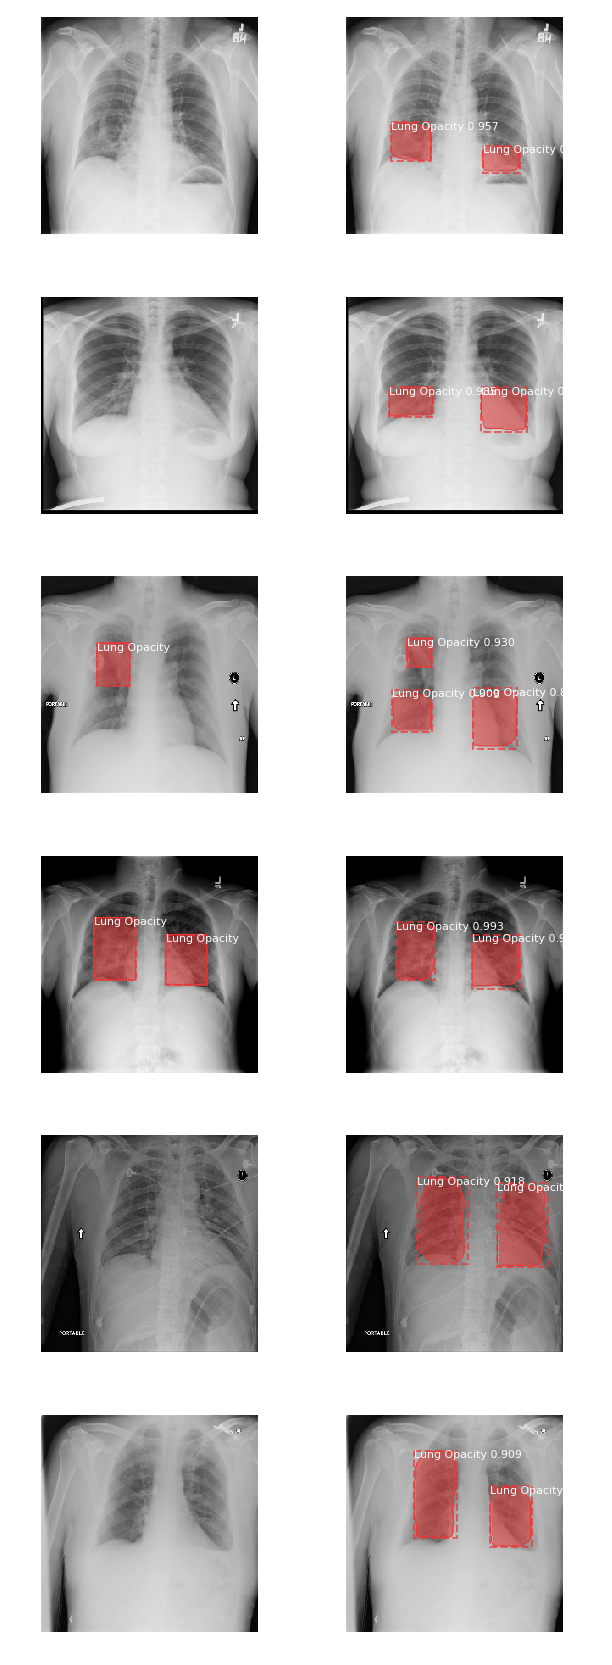

In [57]:
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image])
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

## Predicted

1e493a0c-8faa-4901-9e17-8598a0380ed4
[124  55 186 107]
x 220 y 496 h 208 w 248
[111 142 197 185]
x 568 y 444 h 172 w 344
0d069b31-66d8-439c-bdf2-d1c4b2cf3436
29d42f45-5046-4112-87fa-18ea6ea97e75
[158  58 191 100]
x 232 y 632 h 168 w 132
[155 152 209 198]
x 608 y 620 h 184 w 216
1d06ec84-c515-4b14-91a1-ede09d512711
[ 75 152 185 206]
x 608 y 300 h 216 w 440
[ 72  52 160 112]
x 208 y 288 h 240 w 352


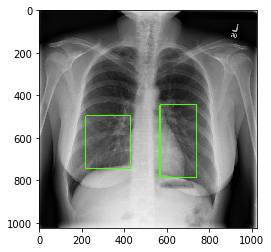

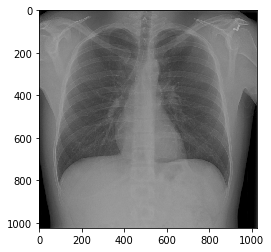

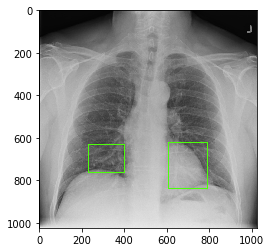

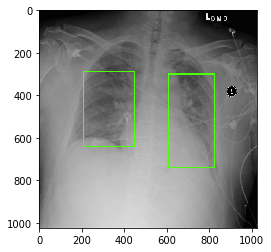

In [62]:
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    image = ds.pixel_array
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()